# Coffee Leaf Diseases Prediction

## Overview
This notebook is a reproduction of the coffee leaf disease classification method described in the research paper below, using machine learning techniques with RGB and CMY color features.

## References

### Research Paper
- **Title**: Comparative Analysis of the Performance of the Decision Tree and K-Nearest Neighbors Methods in Classifying Coffee Leaf Diseases
- **Authors**: Adie Suryadi, Murhaban Murhaban, Rivansyah Suhendra
- **Published in**: Department of Information Technology, Teuku Umar University, Indonesia
- **URL**: [https://aptikom-journal.id/conferenceseries/article/view/649/272](https://aptikom-journal.id/conferenceseries/article/view/649/272)

### Dataset
- **Dataset**: Coffee Leaf Diseases
- **Source**: Kaggle
- **URL**: [https://www.kaggle.com/datasets/badasstechie/coffee-leaf-diseases/code](https://www.kaggle.com/datasets/badasstechie/coffee-leaf-diseases/code)

## Methodology
This implementation extracts color-based features from coffee leaf images:
- **RGB features**: Mean and standard deviation for each R, G, B channel (6 features)
- **CMY features**: Mean and standard deviation for each C, M, Y channel (6 features)
- **Total**: 12 color-based features per image

The features are then used to classify coffee leaves into four categories:
- Miner
- Phoma
- Rust
- No disease

📌 コード全体の流れ（要約）

1.特徴量抽出の準備
- 画像を読み込み、RGBとCMY色空間の各チャンネルから平均値・標準偏差を計算（12次元の特徴量ベクトル）。
- ラベルCSVを読み込み、複数ラベルを単一ラベル（miner, phoma, rust, nodisease）に変換。

2.データ前処理
- 特徴量とラベルを取得。
- 学習用と検証用に分割（train/test split）。
- ラベルを数値化（LabelEncoder）。
- 特徴量を標準化（StandardScaler）。

3.モデル構築とハイパーパラメータ探索
- Decision Tree と KNN を定義。
- GridSearchCVで最適なパラメータを探索（交差検証）。
- 最適モデル (best_model_dt, best_model_knn) を取得。

4.モデル評価
- 学習したモデルで検証データを予測。
- 精度（Accuracy）、適合率（Precision）、再現率（Recall）、F1スコアを micro/macro 平均で算出。
- 混同行列を可視化（heatmap）。
- ROC曲線を描画し、各クラスごとのAUCを確認。

5.モデル保存
- joblibを使って学習済みモデルを .pkl ファイルに保存。
- GridSearchで得た最適モデルと、手動指定パラメータのモデルを両方保存。


## 1. Preprocessing Data

1-1. 画像を読み込み、RGBとCMY色空間の各チャンネルから平均値・標準偏差を計算（12次元の特徴量ベクトル）

全体の流れ
- 画像を読み込む
- RGBとCMYの統計特徴量を抽出（12次元ベクトル）
- ラベルを単一カテゴリに変換
- 特徴量とラベルを返す → 機械学習モデルに入力可能な形になる

この features_array と labels を 学習データとして使えばOK

In [180]:
import numpy as np
from PIL import Image # 画像の読み込み・リサイズなどを行うライブラリ
import os

# 目的: RGB画像を CMY 色空間に変換
def rgb_to_cmy(rgb_image):
    # CMY = 1 - RGB
    cmy_image = 1.0 - rgb_image                 # RGB値は [0,1] に正規化されているので、1 - RGB で簡単に CMY を得られる
    return cmy_image                            # 出力は同じ形状の配列（画像データ）

# 目的: 画像から統計的な色特徴量を抽出。RGBとCMYそれぞれのチャンネルごとに平均値と標準偏差を計算
def extract_color_features(image):
    features = []
    # RGB features (6)
    for channel in range(3):  # R, G, B
        channel_data = image[:, :, channel]
        features.append(np.mean(channel_data))  # Mean
        features.append(np.std(channel_data))   # Standard deviation
    
    # CMY features (6)
    cmy_image = rgb_to_cmy(image)
    for channel in range(3):  # C, M, Y
        channel_data = cmy_image[:, :, channel]
        features.append(np.mean(channel_data))  # Mean
        features.append(np.std(channel_data))   # Standard deviation
    
    return np.array(features)                                   # 合計で 12次元の特徴ベクトル（RGB 6 + CMY 6）

# 目的: データセット全体から特徴量とラベルを作成
def load_and_extract_features(image_dir, labels_df):
    features_list = []
    valid_indices = []
    
    for idx, row in labels_df.iterrows():                       # labels_df → CSVから読み込んだラベル情報（idと病気ラベル）
        img_path = os.path.join(image_dir, f"{row['id']}.jpg")  # img_path → idに対応する画像ファイルを探す
        
        if os.path.exists(img_path):                            # 画像が存在すれば
            img = Image.open(img_path)
            img_resized = img.resize((410, 205)) # resize to 410x205    # 読み込み → リサイズ (410×205) → 正規化 (0〜1)。
            img_array = np.array(img_resized).astype('float32') / 255.0 # normalize
            
            features = extract_color_features(img_array)
            features_list.append(features)                      # 特徴量抽出 → リストに追加
            valid_indices.append(idx)
        else:
            print(f"Warning: {img_path} not found")             # 存在しなければ警告を表示
    
    features_array = np.array(features_list)
    labels = labels_df.loc[valid_indices].reset_index(drop=True)
    
    return features_array, labels                               # 全画像の特徴量 (N×12), 有効なラベル情報　　この features_array と labels を 学習データとして使えばOK

# 目的: 複数ラベル形式（miner, phoma, rust, nodisease）を単一ラベルに変換
def convert_to_single_label(row):
    if row['miner'] == 1:
        return 'miner'
    elif row['phoma'] == 1:
        return 'phoma'
    elif row['rust'] == 1:
        return 'rust'
    else:
        return 'nodisease'

1-2. ラベルCSVを読み込み、複数ラベルを単一ラベル（miner, phoma, rust, nodisease）に変換。

全体の流れ
- CSVからラベルを読み込み → 単一ラベルに変換
- 画像から特徴量を抽出
- 学習用と検証用に分割（クラス比率を維持）
- ラベルを数値化（モデルに渡せる形）
- 特徴量を標準化（学習を安定させる）

これで 「モデルに渡せる形のデータセット」 が完成
- X_train_scaled → 学習用特徴量
- y_train_encoded → 学習用ラベル
- X_valid_scaled → 検証用特徴量
- y_valid_encoded → 検証用ラベル

In [181]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder 
import pandas as pd

train_label_df = pd.read_csv('dataset/train_classes.csv')

# convert_to_single_label 関数を使って、複数ラベル形式（miner, phoma, rust, nodisease）を 単一ラベル文字列 に変換 - 例: miner=1, phoma=0, rust=0 → 'miner'
train_label_df['label'] = train_label_df.apply(convert_to_single_label, axis=1)
print(train_label_df.head()) # ★

# 画像ディレクトリとラベル情報を渡して、各画像から抽出した train_features → 12次元の特徴量ベクトル、train_labels → 有効なラベル情報を取得
train_features, train_labels = load_and_extract_features('dataset/coffee-leaf-diseases/train/images', train_label_df)
print(train_features[:5])        # 特徴量はNumpy　先頭5行の特徴量を表示
print(train_features.shape)      # 特徴量はNumpy　配列の形状 (例: (N, 12))
print(train_labels.head())       # ラベルはDF　　先頭5行のラベルを表示

# 学習用と検証用に分割
X_train, X_valid, y_train, y_valid = train_test_split(
    train_features,
    train_labels['label'],
    test_size=0.2,
    stratify=train_labels['label'],     # クラスの割合を保ったまま分割（偏り防止）
    random_state=123
)

# ラベルの数値化
label_encoder = LabelEncoder()                              # 文字列ラベルを数値に変換。例: ['miner', 'phoma', 'rust', 'nodisease'] → [2, 1, 3, 0] のような整数
y_train_encoded = label_encoder.fit_transform(y_train)      # 学習用データで fit → 検証用データは同じ変換を適用。
y_valid_encoded = label_encoder.transform(y_valid)

# 特徴量の標準化
scaler = StandardScaler()                                   # StandardScaler で特徴量を標準化。平均0、標準偏差1に変換
X_train_scaled = scaler.fit_transform(X_train)              # 学習用データで fit → 検証用データは同じスケーリングを適用
X_valid_scaled = scaler.transform(X_valid)

   id  miner  rust  phoma      label
0   0      0     0      0  nodisease
1   1      0     0      0  nodisease
2   2      0     0      0  nodisease
3   3      0     0      0  nodisease
4   4      0     0      0  nodisease
[[0.62502563 0.2694456  0.6493552  0.2163519  0.49923092 0.35899934
  0.37497443 0.2694456  0.35064486 0.2163519  0.5007691  0.35899934]
 [0.62502563 0.26944563 0.6493551  0.21635191 0.49923092 0.35899934
  0.3749744  0.2694456  0.3506449  0.21635191 0.50076914 0.35899934]
 [0.6250253  0.2694431  0.6493518  0.2163518  0.4992352  0.35899374
  0.37497476 0.2694431  0.35064822 0.2163518  0.5007648  0.35899374]
 [0.6250253  0.2694431  0.6493518  0.2163518  0.4992352  0.35899374
  0.37497473 0.2694431  0.35064822 0.2163518  0.50076485 0.35899374]
 [0.57828003 0.2575277  0.5895637  0.21542728 0.47677955 0.32430255
  0.42171997 0.2575277  0.41043627 0.21542728 0.5232205  0.32430255]]
(1264, 12)
   id  miner  rust  phoma      label
0   0      0     0      0  nodisease
1   1  

## 2.Hyperparameter Tuning

モデル構築とハイパーパラメータ探索

全体の流れ
- 決定木とKNNとNeural Networkを定義。
- それぞれのハイパーパラメータ範囲を指定。
- GridSearchCV で交差検証しながら最適なパラメータを探索。
- 最適なモデル (best_model_dt, best_model_knn) を取得。
- 最適パラメータとスコアを表示。

In [182]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# ---------- Decision Tree ----------
#　max_features=None → 全特徴量を使う。splitter='best' → 最適な分割を選択
dt = DecisionTreeClassifier(max_features=None, random_state=123, splitter='best')

# 探索するハイパーパラメータの範囲を指定 「この範囲の中で試してね」と候補を渡す
param_grid_dt = {
    'criterion': ['gini', 'entropy'],               # 不純度の指標（ジニ係数 or エントロピー）
    'max_depth': list(range(1, 21)) + [None],       # 木の深さ（1〜20、または制限なし）
    'min_samples_split': range(2, 11),              # ノードを分割するための最小サンプル数（2〜10）
    'min_samples_leaf': range(1, 6)                 # 葉ノードに必要な最小サンプル数（1〜5）
}

# GridSearchCVで総当たり探索
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=10) # 10分割交差検証（cv=10）でグリッドサーチを実行
grid_search_dt.fit(X_train_scaled, y_train)             # 学習データ X_train_scaled とラベル y_train を使って最適なパラメータを探索

# 最適なハイパーパラメータを取得
best_model_dt = grid_search_dt.best_estimator_      # 最適なパラメータで学習された決定木モデル
print(grid_search_dt.best_params_)                  # 最適なパラメータの組み合わせ
print(grid_search_dt.best_score_)                   # 交差検証での平均スコア


# ---------- KNN ----------
# algorithm='auto' → 最適なアルゴリズムを自動選択。leaf_size=30 → KDTree/BallTreeの葉サイズ。 p=2 → 距離計算にユークリッド距離（L2ノルム）。 weights='uniform' → 全近傍に同じ重み
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, n_jobs=-1, p=2, weights='uniform')

# 探索するハイパーパラメータの範囲を指定 「この範囲の中で試してね」と候補を渡す
param_grid_knn = {
    'metric': ['euclidean', 'manhattan'],           # 距離の種類（ユークリッド or マンハッタン）
    'n_neighbors': range(1, 21),                    # 近傍数（1〜20）
}

# GridSearchCVで総当たり探索
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=10)  # 10分割交差検証でグリッドサーチを実行
grid_search_knn.fit(X_train_scaled, y_train)

# 最適なハイパーパラメータを取得
best_model_knn = grid_search_knn.best_estimator_    # 最適なパラメータで学習されたKNNモデル
print(grid_search_knn.best_params_)                 # 最適なパラメータの組み合わせ
print(grid_search_knn.best_score_)                  # 交差検証での平均スコア


# ---------- Logistic Regression ----------
lr = LogisticRegression(max_iter=1000, random_state=123)

# 探索するハイパーパラメータの範囲を指定 「この範囲の中で試してね」と候補を渡す
param_grid_lr = {
    'solver': ['lbfgs', 'saga'],                    # 多クラス分類に強い solver
    'C': [0.01, 0.1, 1, 10],                        # 正則化の強さ (小さいほど強い)
    'penalty': ['l2']                               # L2 正則化のみ（sagaならl1も可）
}

# GridSearchCVで総当たり探索
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train_scaled, y_train)

# 最適なパラメータとスコアを表示
best_model_lr = grid_search_lr.best_estimator_
print(grid_search_lr.best_params_)
print(grid_search_lr.best_score_)


# ---------- Neural network ----------
# MLP（多層パーセプトロン）
nn = MLPClassifier(max_iter=1000, random_state=123)

# 探索するハイパーパラメータの範囲を指定 「この範囲の中で試してね」と候補を渡す
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],   # 隠れ層が1層でユニット数が50、-隠れ層が1層でユニット数が100、隠れ層が2層で1層目に100ユニット、2層目に50ユニット
    # adam: Adaptive Moment Estimation 勾配降下法の一種。学習率を自動調整しながら更新。大規模データや特徴量が多い場合強い。小規模データは収束不安定な事がある。
    # lbfgs: Limited-memory BFGS 準ニュートン法の一種。二階微分（ヘッセ行列）を近似して最適化。小〜中規模データセットで非常に効率的。収束が安定しやすい。
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],  # 正則化パラメータ   # 小さい値 (0.0001) 正則化が弱い → モデルが複雑になりやすい → 過学習のリスクあり。大きい値（0.01） モデルがシンプルになる → 汎化性能が上がる可能性あり、ただし学習が難しくなることも。
    'learning_rate_init': [0.001, 0.01]
}

# GridSearchCVで総当たり探索
grid_search_nn = GridSearchCV(estimator=nn, param_grid=param_grid,cv=10, scoring='accuracy', n_jobs=-1) # 10分割交差検証（cv=10）でグリッドサーチを実行
grid_search_nn.fit(X_train_scaled, y_train)     # 学習データ X_train_scaled とラベルy_trainを使って最適なパラメータを探索

# 最適なパラメータとスコアを表示
best_model_nn = grid_search_nn.best_estimator_      # 最適なパラメータで学習されたNeural Networkモデル
print(grid_search_nn.best_params_)                  # 最適なパラメータの組み合わせ
print(grid_search_nn.best_score_)                   # 交差検証での平均スコア

{'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.994059405940594
{'metric': 'euclidean', 'n_neighbors': 1}
0.993069306930693
{'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.7220442632498544
{'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
0.9970297029702969


The best model for Decision Tree goes with below parameter:
- criterion: 'entropy'
- max_depth: 13
- min_samples_leaf: 1
- min_samples_split: 2

The best model for KNN goes with below parameter:
- metric: 'euclidean'
- n_neighbors: 1

The best model for Logistic Regression goes with below parameter:
- C: 10,
- penalty: 'l2'
- solver': 'saga'

The best model for Neural Network goes with below parameter:
- alpha: 0.001
- hidden_layer_sizes: 50
- learning_rate_init: 0.001
- solver: 'lbfgs'


## 3.Find the Best Model
Using the parameters described in the paper

モデル評価

全体の流れ
- 決定木とKNNを定義。
- 学習データで訓練。
- 検証データで予測。
- 精度・適合率・再現率・F1スコアを出力（micro/macro両方）

In [183]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ---------- Decision Tree ----------
# - 決定木を定義（ジニ係数を基準に分割、深さ制限なし）。
# - 学習データで訓練 (fit)。
# - 検証データで予測 (predict) → y_pred_valid_dt。
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    max_features=None,
    min_samples_leaf=1,             # 葉ノード（最終的な分類先）に必要な最小サンプル数　- 値が 1 → 葉ノードに最低1つのサンプルがあればOK。1細かい、5木が浅くなる
    min_samples_split=2,            # ノードを分割するために必要な最小サンプル数 - 値が 2 → ノードに2つ以上サンプルがあれば分割可能。2細かい
    random_state=123,
    splitter='best'
)
dt.fit(X_train_scaled, y_train)
y_pred_valid_dt = dt.predict(X_valid_scaled)

print("\n=== Decision Tree Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_dt))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_dt, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_dt, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_dt, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_dt, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_dt, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_dt, average='macro', zero_division=0))

# ---------- KNN ----------
# - KNNを定義（ユークリッド距離、近傍数=5）。
# - 学習データで訓練。
# - 検証データで予測 → y_pred_valid_knn。
knn = KNeighborsClassifier(
    algorithm='auto',       # 近傍探索に使うアルゴリズムを自動選択 'ball_tree' 'kd_tree' 'brute' 'auto'　autoはサイズや次元に応じて最適な方法を自動選択
    leaf_size=30,           # KD Tree や Ball Tree の「葉ノードのサイズ」 小さい値 → 木が深くなり探索は速いが構築に時間がかかる。大きい値 → 木が浅くなり構築は速いが探索は遅くなる
    metric='minkowski',
    n_jobs=-1,
    n_neighbors=5,
    p=2,                    # Minkowski距離のパラメータ, - p=1 → マンハッタン距離 (L1ノルム)。- p=2 → ユークリッド距離 (L2ノルム)
    weights='uniform'       # すべての近傍に同じ重み ('distance' にすると 距離が近い点ほど重みが大きくなる）
)
knn.fit(X_train_scaled, y_train)
y_pred_valid_knn = knn.predict(X_valid_scaled)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_knn))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_knn, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_knn, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_knn, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_knn, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_knn, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_knn, average='macro', zero_division=0))

# ---------- Logistic Regression ----------
lr = LogisticRegression(
    max_iter=1000,          # 収束しやすいように少し大きめに設定
    solver='lbfgs',         # 多クラス分類に強い
    random_state=123
)

lr.fit(X_train_scaled, y_train)
y_pred_valid_lr = lr.predict(X_valid_scaled)

print("\n=== Logistic Regression Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_lr))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_lr, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_lr, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_lr, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_lr, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_lr, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_lr, average='macro', zero_division=0))


# ---------- Neural Network ----------
nn = MLPClassifier(
    hidden_layer_sizes=(100,),  # 隠れ層ユニット数
    activation='relu',          # 活性化関数
    solver='adam',              # 最適化アルゴリズム: Adaptive Moment Estimation 勾配降下法の一種。学習率を自動調整しながら更新。大規模データや特徴量が多い場合強い。小規模データは収束不安定な事がある。
    # solver='lbfgs',           # 最適化アルゴリズム: : Limited-memory BFGS 準ニュートン法の一種。二階微分（ヘッセ行列）を近似して最適化。小〜中規模データセットで非常に効率的。収束が安定しやすい。
    max_iter=1000,              # 学習回数
    random_state=123
)
nn.fit(X_train_scaled, y_train)
y_pred_valid_nn = nn.predict(X_valid_scaled)

print("\n=== Neural Network Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_nn))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_nn, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_nn, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_nn, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_nn, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_nn, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_nn, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 0.8142292490118577
Precision (micro): 0.8142292490118577
Recall (micro): 0.8142292490118577
F1-score (micro): 0.8142292490118577
Precision (macro): 0.8128058414763226
Recall (macro): 0.8032373328425959
F1-score (macro): 0.8052358752725065

=== Logistic Regression Overall Metrics ===
Accuracy (subset accuracy): 0.6679841897233202
Precision (micro): 0.6679841897233202
Recall (micro): 0.6679841897233202
F1-score (micro): 0.6679841897233202
Precision (macro): 0.6347811733635164
Recall (macro): 0.6392313826524353
F1-score (macro): 0.6349075814536341

=== Neural Network Overall Metrics ===
Accuracy (subset accuracy): 0.841897233201581
Precision (micro): 0.841897233201581
Recall (micro): 0.841897233201581
F1-score (micro): 0.84189723320158

#### Confusion Matrix Heatmap

出力されるもの
- 各セルの数値 → 「実際のラベル vs 予測ラベル」の件数。
- 対角線上の数値が大きいほど「正しく分類できている」ことを意味する。


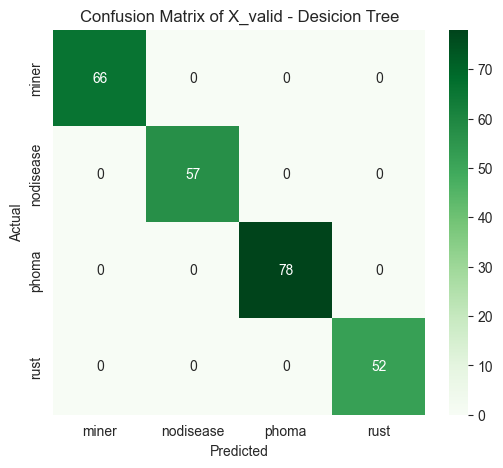

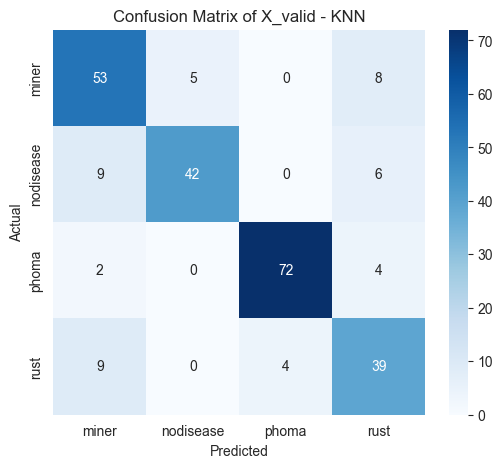

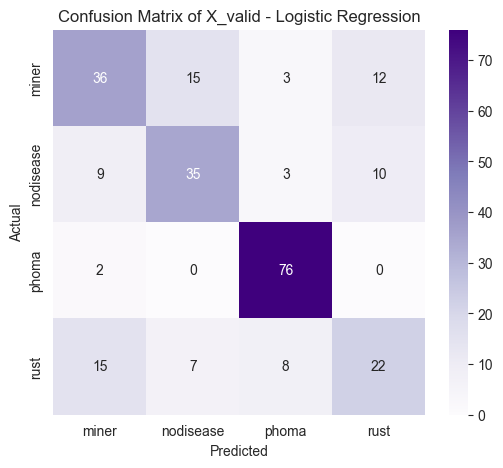

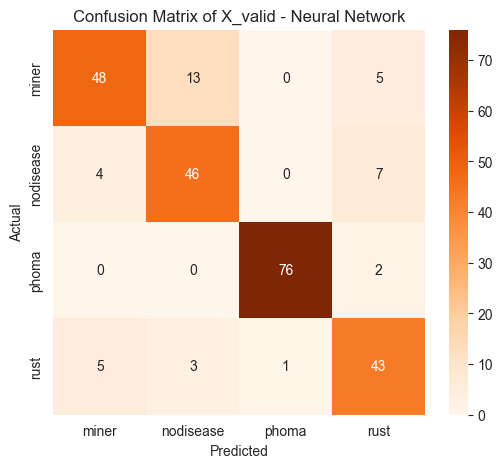

In [184]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = sorted(y_valid.unique())                           # 検証データに含まれるラベルを取得し、ソートして並べる

# Decision Tree
cm_valid_dt = confusion_matrix(y_valid, y_pred_valid_dt)    # 実際のラベル (y_valid) と予測ラベル (y_pred_valid_dt) を比較して混同行列を作成
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_dt,
    annot=True,         # 各セルに数値を表示
    fmt='d',            # 整数表示
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid - Desicion Tree')
plt.show()

# KNN
cm_valid_knn = confusion_matrix(y_valid, y_pred_valid_knn)  # 実際のラベルと KNN の予測ラベルを比較して混同行列を作成
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_knn,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid - KNN')
plt.show()

# Logistic Regression
cm_valid_lr = confusion_matrix(y_valid, y_pred_valid_lr)  # 実際のラベルと Logistic Regression の予測ラベルを比較して混同行列を作成
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_lr,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid - Logistic Regression')
plt.show()

# Neural Network
cm_valid_nn = confusion_matrix(y_valid, y_pred_valid_nn)  # 実際のラベルと NN の予測ラベルを比較して混同行列を作成
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_nn,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid - Neural Network')
plt.show()

#### ROC-AUC Curves

出力されるもの
- 各クラスごとの曲線と AUC 値。
- AUC が 1 に近いほど「分類性能が高い」。
- ランダム分類の基準線（対角線）と比較して性能を確認できる。

ポイント
- ROC曲線は 多クラス分類を One-vs-Rest 形式で評価している。
- AUC値を比較することで「どの病気ラベルが分類しやすい／難しいか」が分かる。
- 例えば「rust の AUC が高い → rust は判別しやすい」「phoma の AUC が低い → phoma は誤分類されやすい」といった分析が可能。

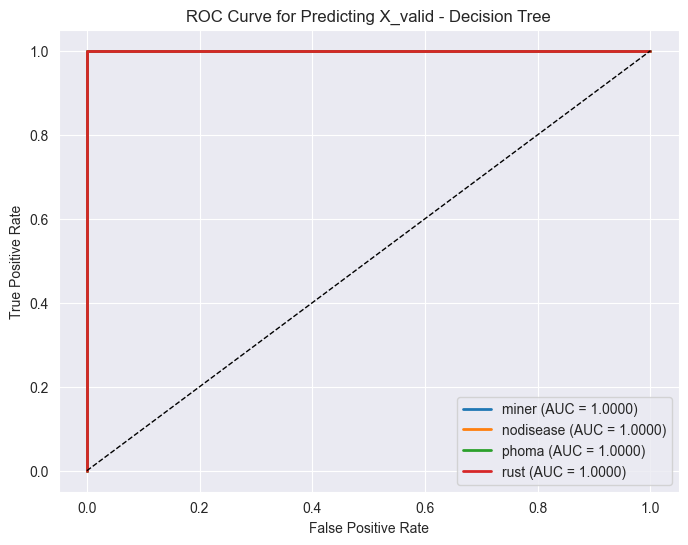

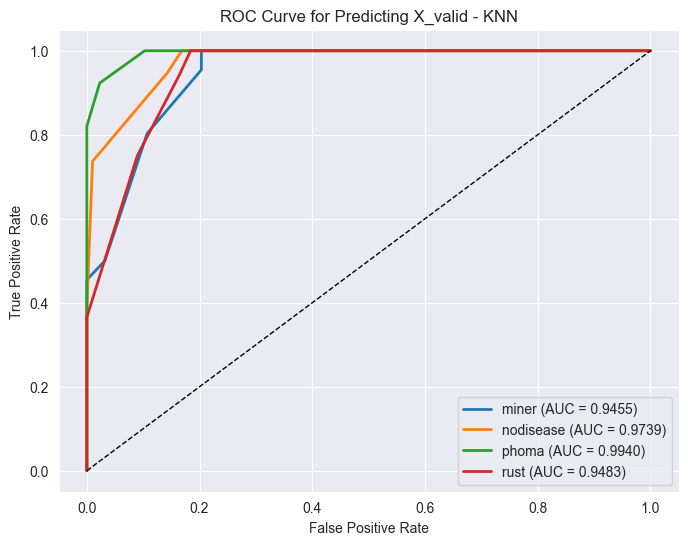

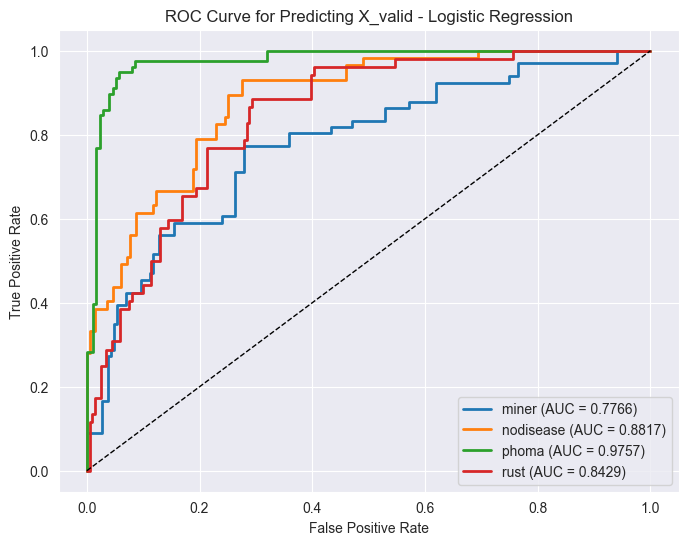

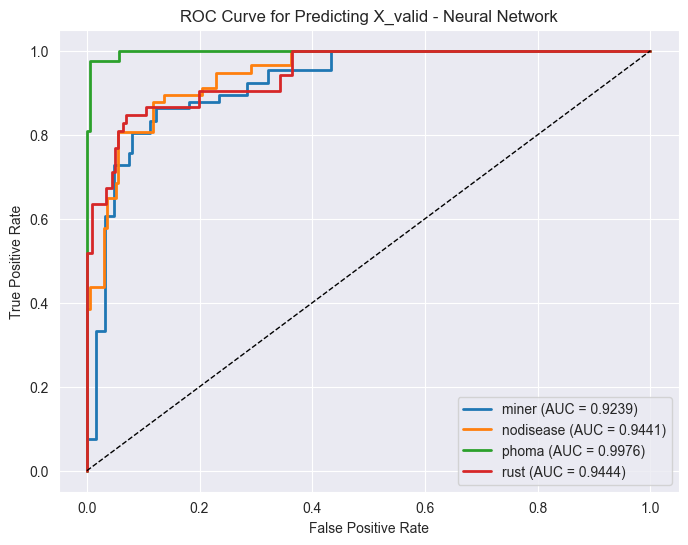

In [185]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Decision Tree
y_score_valid_dt = dt.predict_proba(X_valid_scaled)
y_bin_valid_dt = label_binarize(y_valid, classes=dt.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(dt.classes_):
    fpr_dt, tpr_dt, _ = roc_curve(y_bin_valid_dt[:, i], y_score_valid_dt[:, i])
    roc_auc_dt = auc(fpr_dt, tpr_dt)
    plt.plot(
        fpr_dt,
        tpr_dt,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_dt:.4f})'
    )
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predicting X_valid - Decision Tree')
plt.legend()
plt.show()

# KNN
y_score_valid_knn = knn.predict_proba(X_valid_scaled)
y_bin_valid_knn = label_binarize(y_valid, classes=knn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(knn.classes_):
    fpr_knn, tpr_knn, _ = roc_curve(y_bin_valid_knn[:, i], y_score_valid_knn[:, i])
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    plt.plot(
        fpr_knn,
        tpr_knn,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_knn:.4f})'
    )
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predicting X_valid - KNN')
plt.legend()
plt.show()

# Logistic Regression
y_score_valid_lr = lr.predict_proba(X_valid_scaled)
y_bin_valid_lr = label_binarize(y_valid, classes=lr.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(lr.classes_):
    fpr_lr, tpr_lr, _ = roc_curve(y_bin_valid_lr[:, i], y_score_valid_lr[:, i])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    plt.plot(
        fpr_lr,
        tpr_lr,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_lr:.4f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predicting X_valid - Logistic Regression')
plt.legend()
plt.show()


# Neural Network
y_score_valid_nn = nn.predict_proba(X_valid_scaled)
y_bin_valid_nn = label_binarize(y_valid, classes=nn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(nn.classes_):
    fpr_nn, tpr_nn, _ = roc_curve(y_bin_valid_nn[:, i], y_score_valid_nn[:, i])
    roc_auc_nn = auc(fpr_nn, tpr_nn)
    plt.plot(
        fpr_nn,
        tpr_nn,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_nn:.4f})'
    )
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predicting X_valid - Neural Network')
plt.legend()
plt.show()

## 4.Using the best parameters from CV

GridSearchCVで得たbest_model_xxx を使って検証データを予測

まとめ
- このコードは GridSearchCVで選ばれた最適なモデルを使って評価している
- 以前のコードでは「手動指定パラメータ」で評価していたが、今回は「最適パラメータ」での性能比較
- 出力される指標は Accuracy, Precision, Recall, F1-score を micro/macro 平均で算出
- これで「最適化したモデルがどれくらい改善したか」を確認できる


In [186]:
# ---------- Decision Tree ----------
y_pred_valid_dt_best = best_model_dt.predict(X_valid_scaled)

print("\n=== Decision Tree Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_dt_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_dt_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_dt_best, average='macro', zero_division=0))

# ---------- KNN ----------
y_pred_valid_knn_best = best_model_knn.predict(X_valid_scaled)

print("\n=== KNN Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_knn_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_knn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_knn_best, average='macro', zero_division=0))

# ---------- Logistic Regression ----------
y_pred_valid_lr_best = best_model_lr.predict(X_valid_scaled)

print("\n=== Logistic Regression Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_lr_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_lr_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_lr_best, average='macro', zero_division=0))

# ---------- Neural Network ----------
y_pred_valid_nn_best = best_model_nn.predict(X_valid_scaled)

print("\n=== Nueral Network Overall Metrics ===")
print("Accuracy (subset accuracy):", accuracy_score(y_valid, y_pred_valid_nn_best))
print("Precision (micro):", precision_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("Recall (micro):", recall_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("F1-score (micro):", f1_score(y_valid, y_pred_valid_nn_best, average='micro', zero_division=0))
print("Precision (macro):", precision_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))
print("Recall (macro):", recall_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))
print("F1-score (macro):", f1_score(y_valid, y_pred_valid_nn_best, average='macro', zero_division=0))


=== Decision Tree Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== KNN Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0

=== Logistic Regression Overall Metrics ===
Accuracy (subset accuracy): 0.7114624505928854
Precision (micro): 0.7114624505928854
Recall (micro): 0.7114624505928854
F1-score (micro): 0.7114624505928854
Precision (macro): 0.6890723503244232
Recall (macro): 0.6926297386823703
F1-score (macro): 0.6890021862403498

=== Nueral Network Overall Metrics ===
Accuracy (subset accuracy): 1.0
Precision (micro): 1.0
Recall (micro): 1.0
F1-score (micro): 1.0
Precision (macro): 1.0
Recall (macro): 1.0
F1-score (macro): 1.0


#### Confusion Matrix Heatmap

混同行列（Decision Tree: 緑、KNN: 青）

→ 正解数は対角線上、誤分類は対角線外。


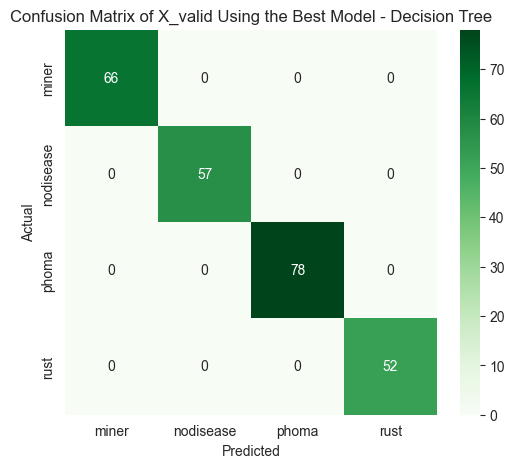

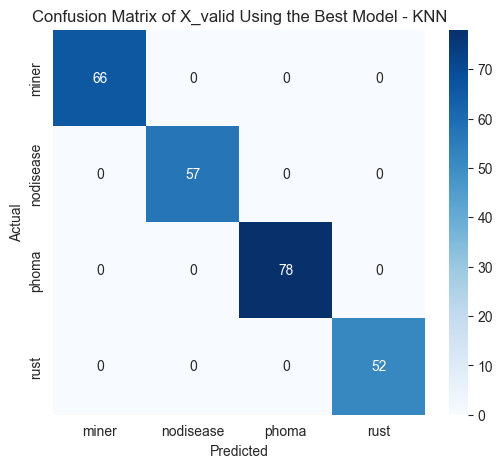

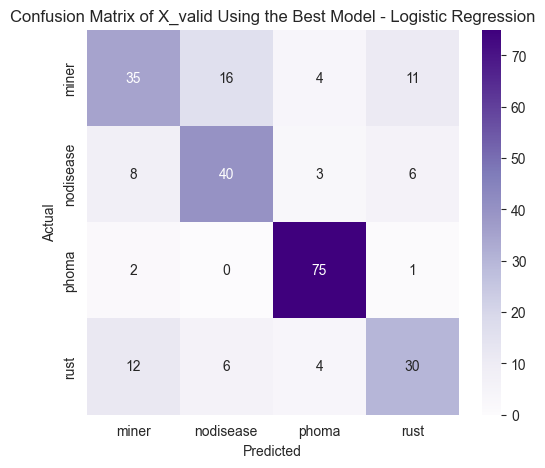

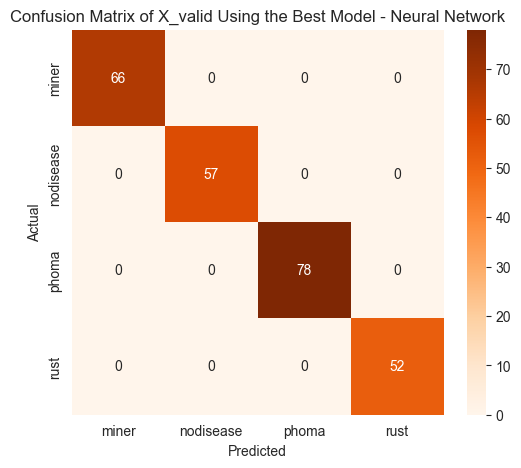

In [187]:
# Decision Tree
cm_valid_dt_best = confusion_matrix(y_valid, y_pred_valid_dt_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_dt_best,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid Using the Best Model - Decision Tree')
plt.show()

# KNN
cm_valid_knn_best = confusion_matrix(y_valid, y_pred_valid_knn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_knn_best,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid Using the Best Model - KNN')
plt.show()

# Logistic Regression
cm_valid_lr_best = confusion_matrix(y_valid, y_pred_valid_lr_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_lr_best,
    annot=True,
    fmt='d',
    cmap='Purples',          # 他モデルと区別するため紫系に設定
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid Using the Best Model - Logistic Regression')
plt.show()

# Neural Network
cm_valid_nn_best = confusion_matrix(y_valid, y_pred_valid_nn_best)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_valid_nn_best,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of X_valid Using the Best Model - Neural Network')
plt.show()

#### ROC-AUC Curves

ROC曲線（各クラスごとに曲線とAUC値）

→ どの病気ラベルが分類しやすい／難しいかが分かる。


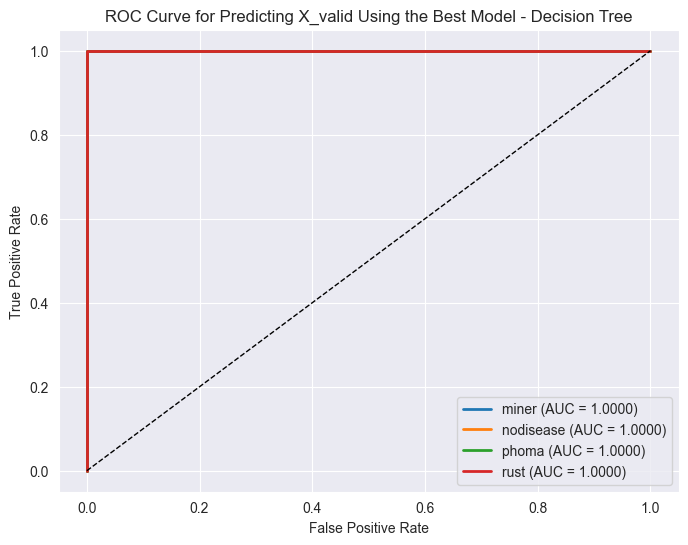

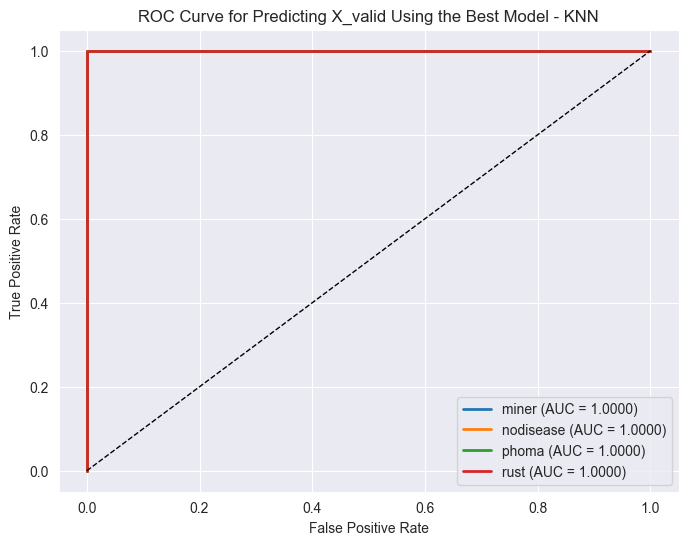

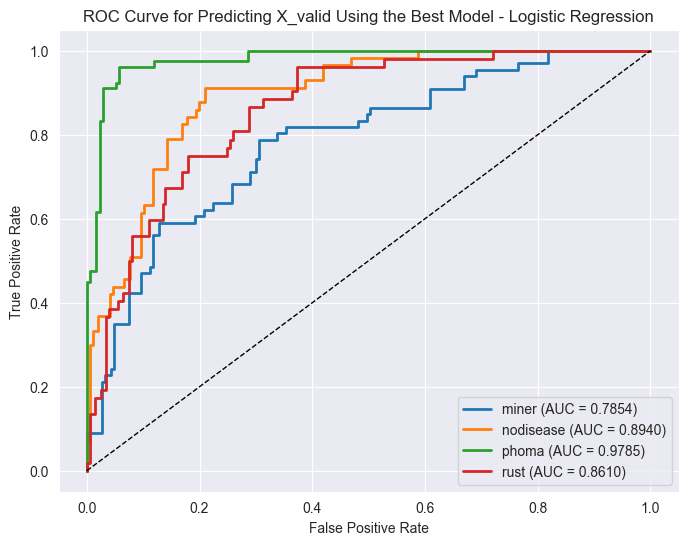

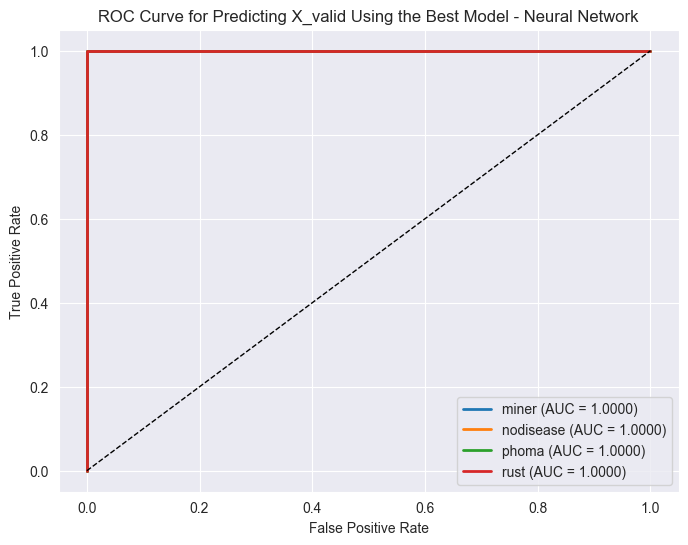

In [188]:
# Decision Tree
y_score_valid_dt_best = best_model_dt.predict_proba(X_valid_scaled)
y_bin_valid_dt_best = label_binarize(y_valid, classes=best_model_dt.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_dt.classes_):
    fpr_dt, tpr_dt, _ = roc_curve(y_bin_valid_dt_best[:, i], y_score_valid_dt_best[:, i])
    roc_auc_dt_best = auc(fpr_dt, tpr_dt)
    plt.plot(
        fpr_dt,
        tpr_dt,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_dt_best:.4f})'
    )
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predicting X_valid Using the Best Model - Decision Tree')
plt.legend()
plt.show()

# KNN
y_score_valid_knn_best = best_model_knn.predict_proba(X_valid_scaled)
y_bin_valid_knn_best = label_binarize(y_valid, classes=best_model_knn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_knn.classes_):
    fpr_knn, tpr_knn, _ = roc_curve(y_bin_valid_knn_best[:, i], y_score_valid_knn_best[:, i])
    roc_auc_knn_best = auc(fpr_knn, tpr_knn)
    plt.plot(
        fpr_knn,
        tpr_knn,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_knn_best:.4f})'
    )
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predicting X_valid Using the Best Model - KNN')
plt.legend()
plt.show()

# Logistic Regression
y_score_valid_lr_best = best_model_lr.predict_proba(X_valid_scaled)
y_bin_valid_lr_best = label_binarize(y_valid, classes=best_model_lr.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_lr.classes_):
    fpr_lr, tpr_lr, _ = roc_curve(y_bin_valid_lr_best[:, i], y_score_valid_lr_best[:, i])
    roc_auc_lr_best = auc(fpr_lr, tpr_lr)
    plt.plot(
        fpr_lr,
        tpr_lr,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_lr_best:.4f})'
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predicting X_valid Using the Best Model - Logistic Regression')
plt.legend()
plt.show()

# Neural Network
y_score_valid_nn_best = best_model_nn.predict_proba(X_valid_scaled)
y_bin_valid_nn_best = label_binarize(y_valid, classes=best_model_nn.classes_)
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(best_model_nn.classes_):
    fpr_nn, tpr_nn, _ = roc_curve(y_bin_valid_nn_best[:, i], y_score_valid_nn_best[:, i])
    roc_auc_nn_best = auc(fpr_nn, tpr_nn)
    plt.plot(
        fpr_nn,
        tpr_nn,
        lw=2,
        label=f'{class_name} (AUC = {roc_auc_nn_best:.4f})'
    )
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predicting X_valid Using the Best Model - Neural Network')
plt.legend()
plt.show()

## 5.Save models

To save scikit-learn models, we use `joblib` which is more efficient for large numpy arrays:

In [189]:
import joblib # -  Pythonオブジェクトを効率的に保存・読み込みできるライブラリ。特に scikit-learn のモデル保存に適している（pickleより高速で大きな配列も扱いやすい）

joblib.dump(best_model_knn, 'best_model_knn.pkl')   # GridSearchCVで見つけた 最適なモデルを best_model_xxx.pkl に保存
joblib.dump(best_model_dt, 'best_model_dt.pkl')
joblib.dump(best_model_lr, 'best_model_lr.pkl')
joblib.dump(best_model_nn, 'best_model_dt.pkl')
joblib.dump(dt, 'decision_tree_model.pkl')          # 手動でパラメータ指定したモデルを保存
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(lr, 'logistic_regression_model.pkl')
joblib.dump(knn, 'nn_model.pkl')

['nn_model.pkl']

# Akiko Part おまけ

- Hierarchical Clustering → 教師なし学習 → ラベル付き分類タスクには不利。
- Neural Network (MLPClassifier) → 教師あり学習 → ラベルを使って学習するので分類精度が高い。


## Hierarchical Clustering

GridSearchCV は「教師あり学習モデルのハイパーパラメータ探索」、階層的クラスタリング (Hierarchical Clustering) は教師なし学習なので、GridSearchCV のように「最適パラメータを交差検証で探す」ことはできない



=== Confusion Matrix (Hierarchical Clustering - Valid Data) ===
[[20 15 16 15]
 [12 11 19 15]
 [60  2 14  2]
 [15 15  7 15]]

=== Classification Report (Hierarchical Clustering - Valid Data) ===
              precision    recall  f1-score   support

       miner       0.19      0.30      0.23        66
   nodisease       0.26      0.19      0.22        57
       phoma       0.25      0.18      0.21        78
        rust       0.32      0.29      0.30        52

    accuracy                           0.24       253
   macro avg       0.25      0.24      0.24       253
weighted avg       0.25      0.24      0.24       253



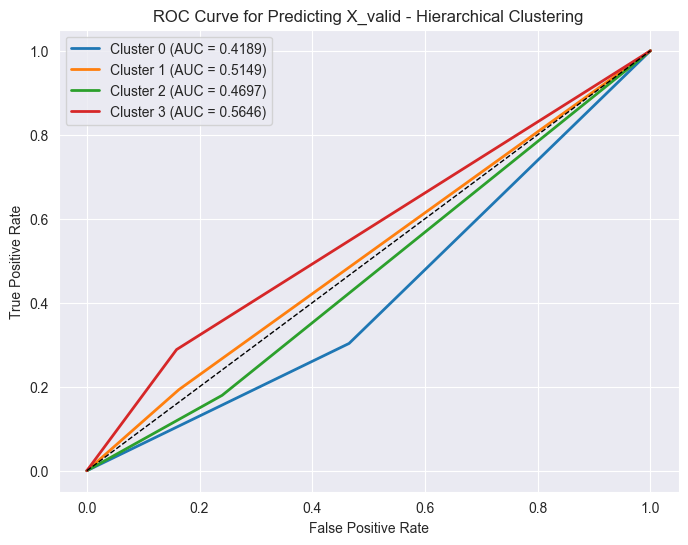

In [190]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ---------- モデル定義 ----------
hc = AgglomerativeClustering(
    n_clusters=len(label_encoder.classes_),  # クラス数に合わせる
    linkage='ward'                           # linkage方法 ('ward', 'complete', 'average' など)
)

# ---------- 学習 & 予測 ----------
y_pred_valid_hc = hc.fit_predict(X_valid_scaled)

# ---------- Confusion Matrix ----------
cm_valid_hc = confusion_matrix(y_valid_encoded, y_pred_valid_hc)
print("\n=== Confusion Matrix (Hierarchical Clustering - Valid Data) ===")
print(cm_valid_hc)

# ---------- Classification Report ----------
print("\n=== Classification Report (Hierarchical Clustering - Valid Data) ===")
print(classification_report(y_valid_encoded, y_pred_valid_hc, target_names=label_encoder.classes_))

# ---------- ROC-AUC (参考値) ----------
# クラスタ番号を one-hot 化
y_bin_valid_hc = label_binarize(y_valid_encoded, classes=range(len(label_encoder.classes_)))
y_score_valid_hc = label_binarize(y_pred_valid_hc, classes=range(len(label_encoder.classes_)))

plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    fpr_hc, tpr_hc, _ = roc_curve(y_bin_valid_hc[:, i], y_score_valid_hc[:, i])
    roc_auc_hc = auc(fpr_hc, tpr_hc)
    plt.plot(fpr_hc, tpr_hc, lw=2, label=f'Cluster {i} (AUC = {roc_auc_hc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Predicting X_valid - Hierarchical Clustering')
plt.legend()
plt.show()
